## Import Libraries


### CUDA


In [1]:
!nvidia-smi

Mon Dec 11 21:59:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   26C    P5    19W / 160W |    399MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import another Libraries

In [52]:
import pandas as pd
from IPython.display import display
pd.set_option('display.max_columns', None) 
pd.set_option('display.float_format', '{:.3f}'.format)

import warnings
warnings.filterwarnings('ignore')

import pickle
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score,KFold,StratifiedKFold

from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from catboost.utils import get_roc_curve


## Converting data types

In [96]:
df_prepared = pd.read_csv('../data/df_prepared.csv')
df_prepared = df_sessions_with_target.copy()
print(df_prepared.shape)
df_prepared.head(5)

(1897005, 18)


,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_action
0,9055434745589932991.1637753792.1637753792,2108382700.164,2021-11-24,14:36:32,1.000,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.164,2021-11-14,08:21:30,1.000,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.164,2021-12-28,02:42:06,1.000,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.162,2021-05-29,05:00:00,1.000,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.162,2021-05-29,05:00:00,2.000,kjsLglQLzykiRbcDiGcD,cpc,other,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0


In [97]:
df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1897005 entries, 0 to 1897106
Data columns (total 18 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   session_id                object 
 1   client_id                 object 
 2   visit_date                object 
 3   visit_time                object 
 4   visit_number              float64
 5   utm_source                object 
 6   utm_medium                object 
 7   utm_campaign              object 
 8   utm_adcontent             object 
 9   utm_keyword               object 
 10  device_category           object 
 11  device_os                 object 
 12  device_brand              object 
 13  device_screen_resolution  object 
 14  device_browser            object 
 15  geo_country               object 
 16  geo_city                  object 
 17  event_action              int64  
dtypes: float64(1), int64(1), object(16)
memory usage: 275.0+ MB


In [98]:
df_prepared.isnull().sum()

session_id                  0
client_id                   0
visit_date                  0
visit_time                  0
visit_number                0
utm_source                  0
utm_medium                  0
utm_campaign                0
utm_adcontent               0
utm_keyword                 0
device_category             0
device_os                   0
device_brand                0
device_screen_resolution    0
device_browser              0
geo_country                 0
geo_city                    0
event_action                0
dtype: int64

In [99]:
df_prepared.visit_date = pd.to_datetime(df_prepared.visit_date, utc=True)
df_prepared.visit_time = pd.to_datetime(df_prepared.visit_time, utc=True)

In [100]:
df_prepared.visit_number.value_counts()

visit_number
1.000      1398641
2.000       241388
3.000        83499
4.000        43320
5.000        25204
            ...   
446.000          1
447.000          1
448.000          1
449.000          1
564.000          1
Name: count, Length: 537, dtype: int64

In [101]:
df_prepared.visit_number = df_prepared.visit_number.astype("float32")
df_prepared.event_action = df_prepared.event_action.astype("int32")

In [102]:
df_prepared.columns.unique()

Index(['session_id', 'client_id', 'visit_date', 'visit_time', 'visit_number',
       'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_screen_resolution', 'device_browser', 'geo_country', 'geo_city',
       'event_action'],
      dtype='object')

In [103]:
columns_for_category = ['session_id', 'client_id', 'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_screen_resolution', 'device_browser', 'geo_country', 'geo_city']

In [104]:
df_prepared[columns_for_category] = df_prepared[columns_for_category].astype("category")

In [105]:
df_prepared.describe().round(2)

,visit_number,event_action
count,1897005.000,1897005.000
mean,2.830,0.050
std,13.400,0.210
min,1.000,0.000
25%,1.000,0.000
50%,1.000,0.000
75%,2.000,0.000
max,564.000,1.000


In [106]:
df_for_feature = df_prepared.copy()

In [107]:
df_prepared.to_csv('../data/df_for_feature.csv', index=False)

##  Feature engineering

In [108]:
# df_for_feature = pd.read_csv('../data/df_for_feature.csv')
print(df_for_feature.shape)
df_for_feature.head(5)

(1897005, 18)


,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_action
0,9055434745589932991.1637753792.1637753792,2108382700.164,2021-11-24 00:00:00+00:00,2023-12-11 14:36:32+00:00,1.000,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.164,2021-11-14 00:00:00+00:00,2023-12-11 08:21:30+00:00,1.000,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.164,2021-12-28 00:00:00+00:00,2023-12-11 02:42:06+00:00,1.000,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.162,2021-05-29 00:00:00+00:00,2023-12-11 05:00:00+00:00,1.000,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.162,2021-05-29 00:00:00+00:00,2023-12-11 05:00:00+00:00,2.000,kjsLglQLzykiRbcDiGcD,cpc,other,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0


In [109]:
df_for_feature['visit_year'] = df_for_feature.visit_date.dt.year.astype('int32')
df_for_feature['visit_month'] = df_for_feature.visit_date.dt.month.astype('int32')
df_for_feature['visit_day'] = df_for_feature.visit_date.dt.day.astype('int32')


In [110]:
df_for_feature.drop('visit_date',axis=1, inplace=True)

In [111]:
df_for_feature['visit_hour'] = df_for_feature.visit_time.dt.hour.astype('int32')
df_for_feature['visit_minute'] = df_for_feature.visit_time.dt.minute.astype('int32')


In [112]:
df_for_feature.drop('visit_time',axis=1, inplace=True)

In [113]:
df_for_feature.drop('session_id',axis=1, inplace=True)

In [114]:
df_for_feature.device_screen_resolution.value_counts()

device_screen_resolution
414x896      172471
1920x1080    128129
375x812      120540
393x851      117561
375x667       95227
              ...  
360x941           1
360x942           1
360x945           1
360x946           1
999x699           1
Name: count, Length: 5039, dtype: int64

In [115]:
df_for_feature['device_screen_width'] = df_for_feature.device_screen_resolution.apply(lambda x: x.split('x')[0])

In [116]:
df_for_feature['device_screen_heiht'] = df_for_feature.device_screen_resolution.apply(lambda x: x.split('x')[-1])

In [117]:
df_for_feature.drop('device_screen_resolution',axis=1, inplace=True)

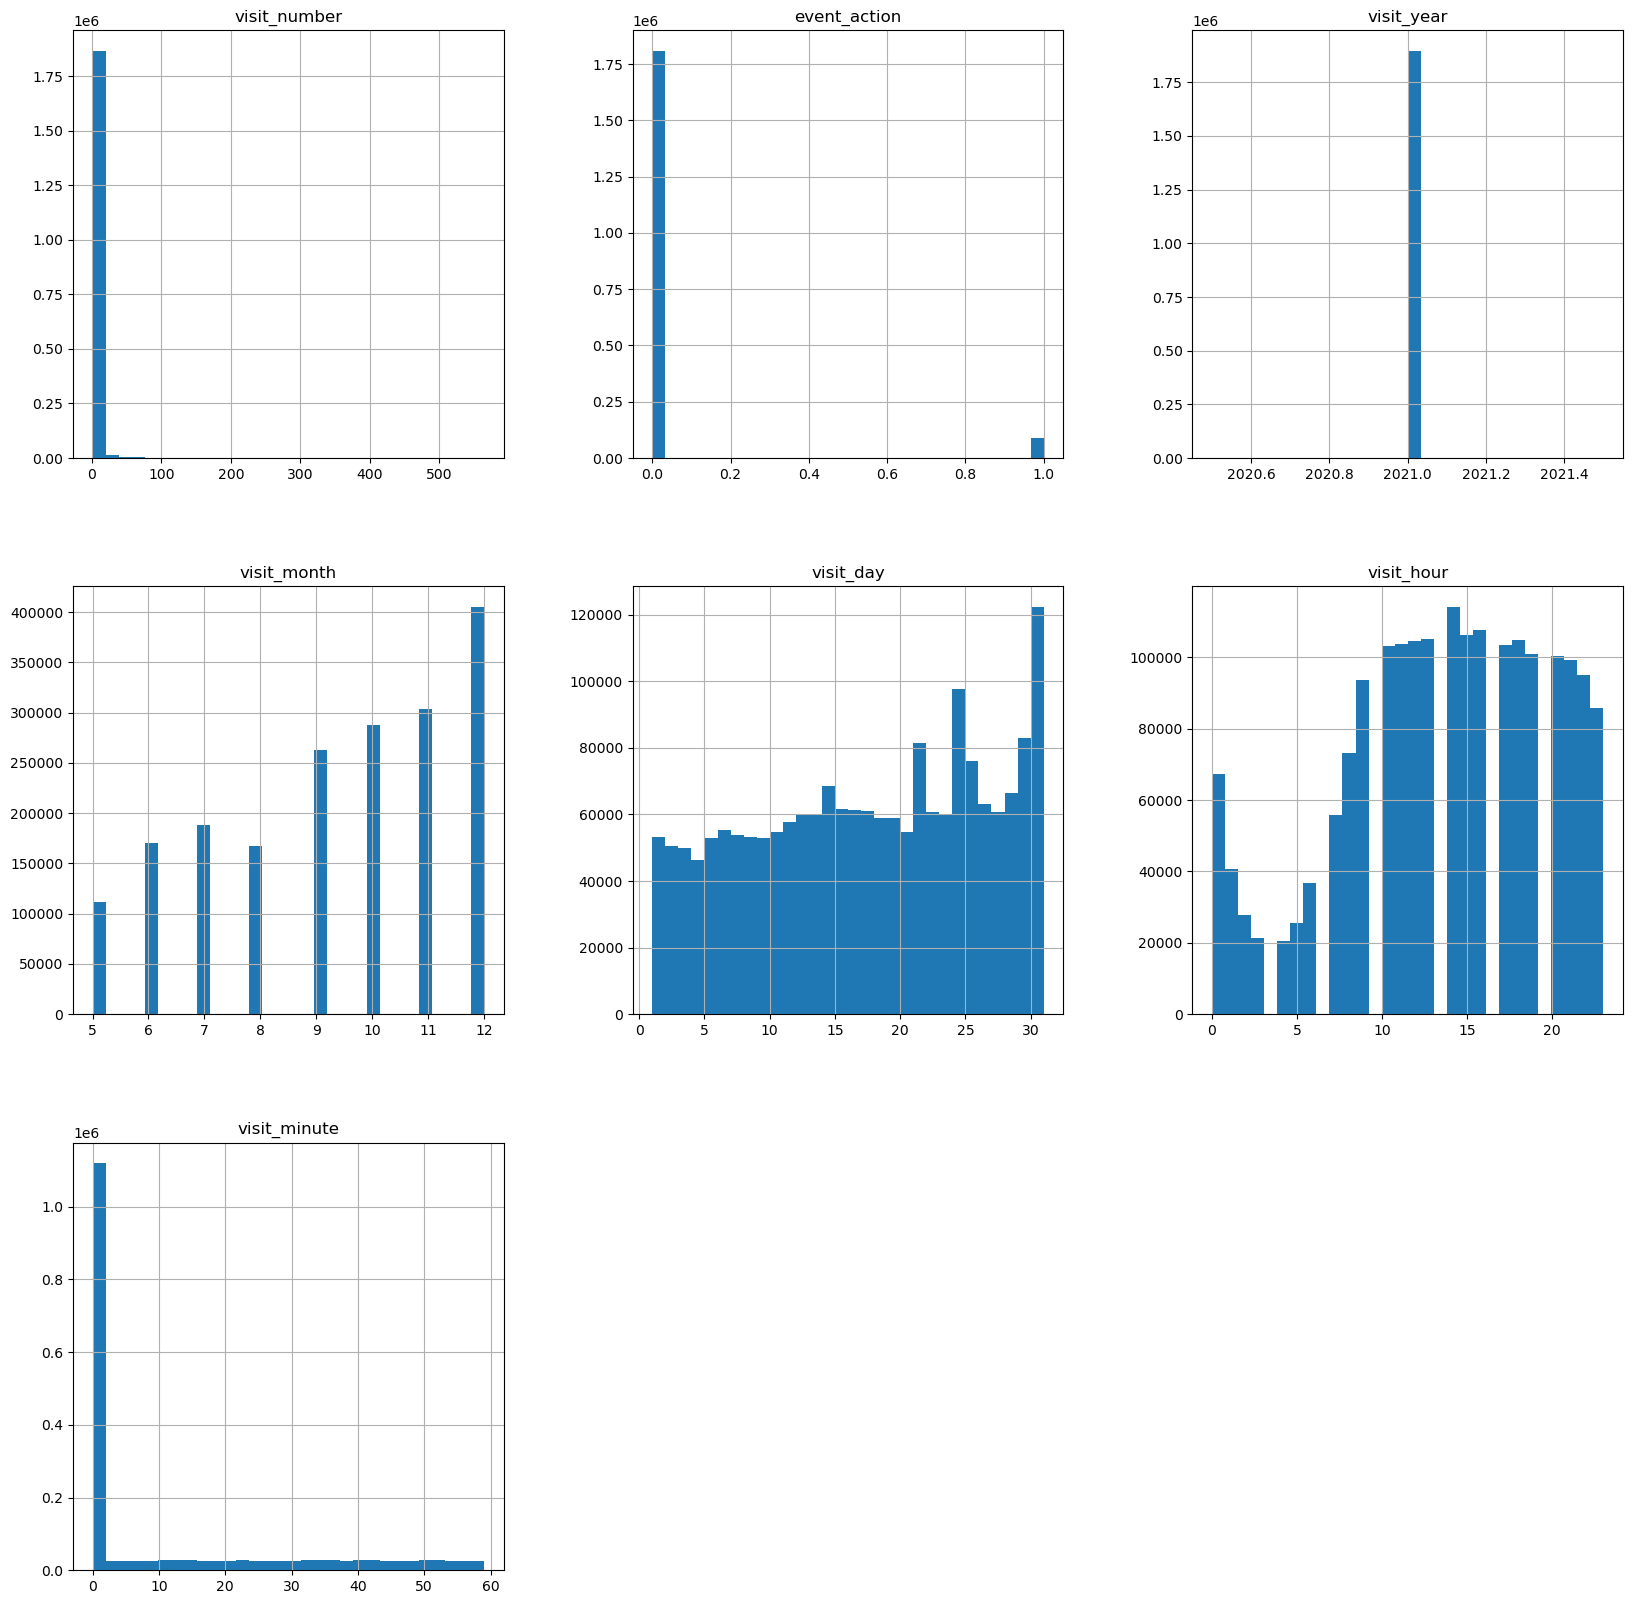

In [118]:
df_for_feature.hist(figsize=(20, 20), bins=30);

In [119]:
df_for_feature.visit_year.value_counts()

visit_year
2021    1897005
Name: count, dtype: int64

In [120]:
df_for_feature.drop('visit_year',axis=1, inplace=True)

In [121]:
df_for_feature.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1897005 entries, 0 to 1897106
Data columns (total 20 columns):
 #   Column               Dtype   
---  ------               -----   
 0   client_id            category
 1   visit_number         float32 
 2   utm_source           category
 3   utm_medium           category
 4   utm_campaign         category
 5   utm_adcontent        category
 6   utm_keyword          category
 7   device_category      category
 8   device_os            category
 9   device_brand         category
 10  device_browser       category
 11  geo_country          category
 12  geo_city             category
 13  event_action         int32   
 14  visit_month          int32   
 15  visit_day            int32   
 16  visit_hour           int32   
 17  visit_minute         int32   
 18  device_screen_width  object  
 19  device_screen_heiht  object  
dtypes: category(12), float32(1), int32(5), object(2)
memory usage: 169.7+ MB


In [122]:
df_for_feature.columns.to_list()

['client_id',
 'visit_number',
 'utm_source',
 'utm_medium',
 'utm_campaign',
 'utm_adcontent',
 'utm_keyword',
 'device_category',
 'device_os',
 'device_brand',
 'device_browser',
 'geo_country',
 'geo_city',
 'event_action',
 'visit_month',
 'visit_day',
 'visit_hour',
 'visit_minute',
 'device_screen_width',
 'device_screen_heiht']

In [123]:
df_for_feature.device_screen_width = df_for_feature.device_screen_width.replace('(not set)', 0)
df_for_feature.device_screen_heiht = df_for_feature.device_screen_heiht.replace('(not set)', 0)

df_for_feature.device_screen_width = df_for_feature.device_screen_width.astype("int32")
df_for_feature.device_screen_heiht = df_for_feature.device_screen_heiht.astype("int32")


In [124]:
df_for_feature.to_csv('../data/df_for_modeling.csv', index=False)

## Modeling


In [69]:
df_for_feature = pd.read_csv('../data/df_for_modeling.csv')
df_for_feature.sample(5)

,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_browser,geo_country,geo_city,event_action,visit_month,visit_day,visit_hour,visit_minute,device_screen_width,device_screen_heiht
482895,668524865.1635521370,1.000,jaSOmLICuBzCFqHfBdRg,email,bxOTvPtyGSdUrbwoXCPO,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,Safari,Russia,Moscow,0,10,29,18,29,414,896
874392,1068054256.163,1.000,ZpYIoDJMcFzVoPFsHGJL,push,YDIkQmcjRkpdxGbLLtNN,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,Chrome,Russia,Moscow,0,10,21,16,0,412,915
1552252,1756844733.164,1.000,kjsLglQLzykiRbcDiGcD,cpc,XHNUiSKKGTEpSAlaVMFQ,JNHcPlZPxEMWDnRiyoBf,ITfrGJNwVsHBGJMAKoct,mobile,iOS,Apple,Safari,Russia,Moscow,0,10,25,15,34,375,667
88163,265375996.163,1.000,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,Chrome,Russia,Chelyabinsk,0,7,14,14,0,393,851
394260,578647536.163,1.000,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,Chrome,Russia,Moscow,0,10,6,11,0,360,740


### CatBost

In [70]:
drop_cols = ['client_id', 'event_action']
cat_features = ['utm_source',
 'utm_medium',
 'utm_campaign',
 'utm_adcontent',
 'utm_keyword',
 'device_category',
 'device_os',
 'device_brand',
 'device_browser',
 'geo_country',
 'geo_city']



In [6]:
n_splits = 3  # Число фолдов. Оптимально 3, 5 или 10
clfs = [] # Тут будем сохранять модели
scores = [] # Тут будем хранить скоры валидационных фолдов

# параметры валидации, обучение будет идти на n_splits фолдах
X = df_for_feature.drop(drop_cols, axis=1, errors = 'ignore')
y = df_for_feature['event_action']

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Специальный класс для ускорения обучения 
    train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
    eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)

    clf = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.06,
        eval_metric='AUC',  
        task_type="CPU",    
        thread_count=-1,   
        random_seed=42,
        auto_class_weights="SqrtBalanced",
        early_stopping_rounds=100)

    clfs.append(clf)

    clf.fit(
        train_dataset,
        eval_set=eval_dataset,
        verbose=100,
        use_best_model=True,
        plot=False)

  
    scores.append(np.mean([v for k, v in clf.best_score_["validation"].items() if "AUC" in k], dtype="float16"))

assert len(clfs) == n_splits
print("mean AUC score --------->", np.mean(scores, dtype="float16") - np.std(scores, dtype="float16"))

0:	test: 0.6197788	best: 0.6197788 (0)	total: 779ms	remaining: 12m 57s
100:	test: 0.7349351	best: 0.7349351 (100)	total: 1m 10s	remaining: 10m 27s
200:	test: 0.7460860	best: 0.7460860 (200)	total: 2m 28s	remaining: 9m 51s
300:	test: 0.7507951	best: 0.7507951 (300)	total: 3m 45s	remaining: 8m 43s
400:	test: 0.7545874	best: 0.7545874 (400)	total: 5m 1s	remaining: 7m 30s
500:	test: 0.7582779	best: 0.7582779 (500)	total: 6m 16s	remaining: 6m 14s
600:	test: 0.7608913	best: 0.7608913 (600)	total: 7m 34s	remaining: 5m 1s
700:	test: 0.7628374	best: 0.7628374 (700)	total: 8m 52s	remaining: 3m 47s
800:	test: 0.7643730	best: 0.7643730 (800)	total: 10m 13s	remaining: 2m 32s
900:	test: 0.7655728	best: 0.7655728 (900)	total: 11m 34s	remaining: 1m 16s
999:	test: 0.7668922	best: 0.7668922 (999)	total: 12m 53s	remaining: 0us

bestTest = 0.7668921895
bestIteration = 999

0:	test: 0.6238460	best: 0.6238460 (0)	total: 770ms	remaining: 12m 48s
100:	test: 0.7367011	best: 0.7367011 (100)	total: 1m 13s	remain

In [10]:
# посмотрим на важность признаков катбуста
fi = clfs[0].get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,utm_campaign,14.491
1,utm_medium,12.277
2,utm_source,9.743
3,utm_adcontent,8.185
4,visit_month,7.918
5,visit_number,6.905
6,device_screen_heiht,6.848
7,geo_city,4.711
8,device_screen_width,4.581
9,visit_day,4.094


#### Feature Importance

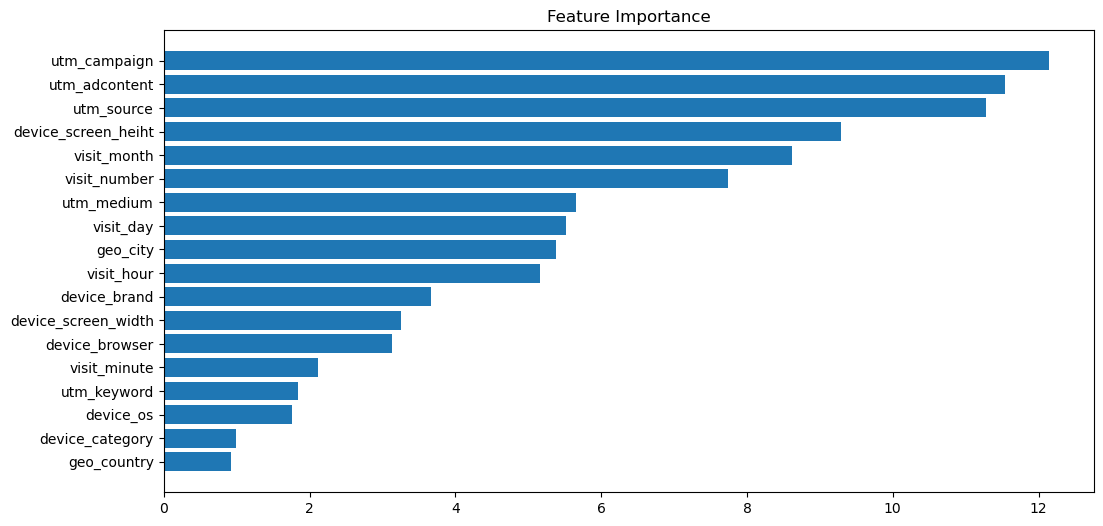

In [52]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');

#### Permutation importance

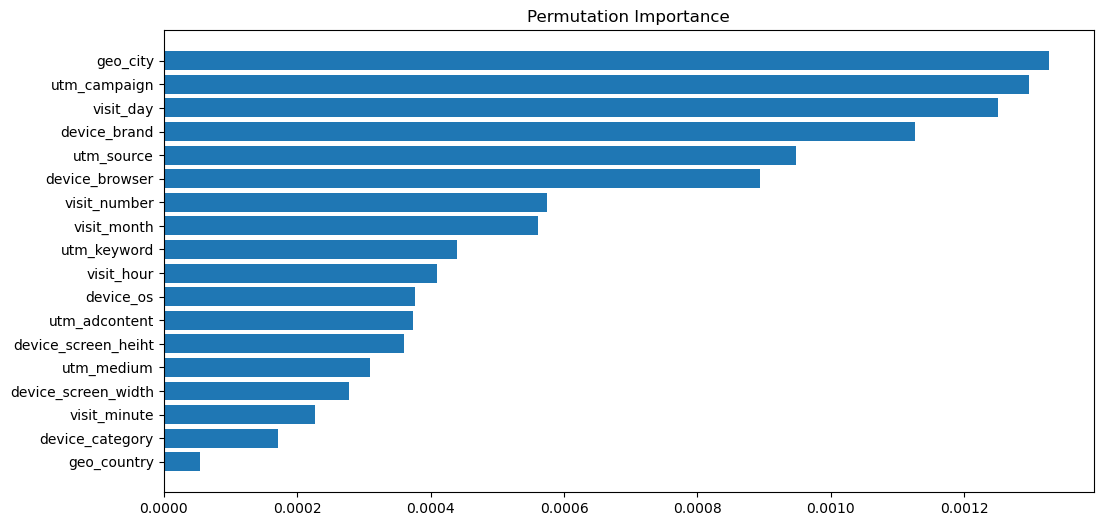

In [378]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

#### SHAP values 

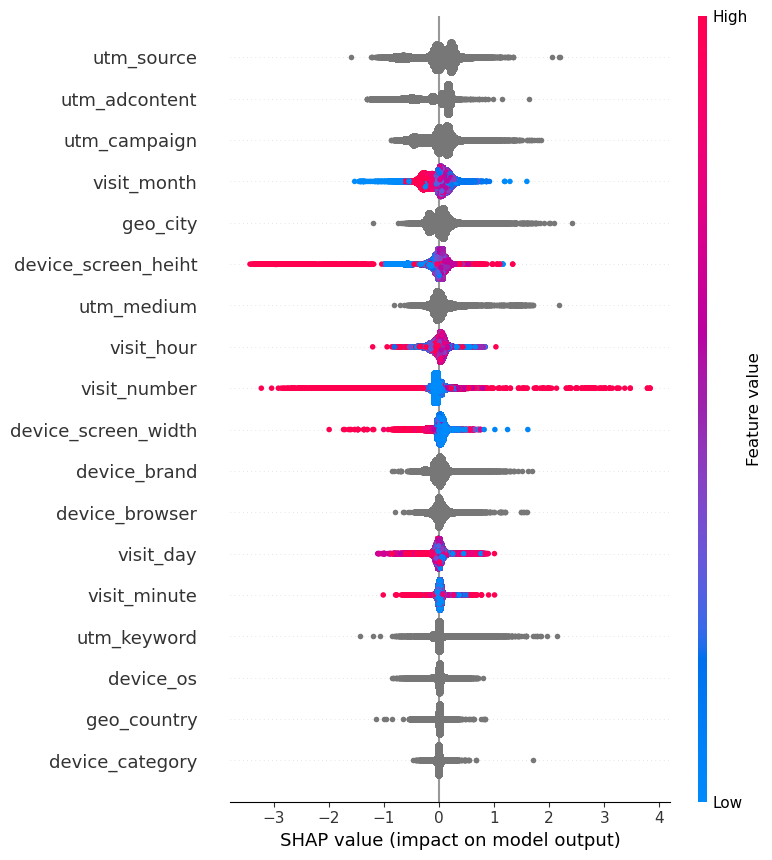

In [53]:
import shap
# Посмотрим на SHAP values
explainer = shap.TreeExplainer(model)

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_cols)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display = 25)

In [15]:
eval_pool = Pool(X_test, y_test, c=cat_features)
curve = get_roc_curve(clfs[0], eval_pool)
(fpr, tpr, thresholds)=curve
roc_auc=auc(fpr, tpr)

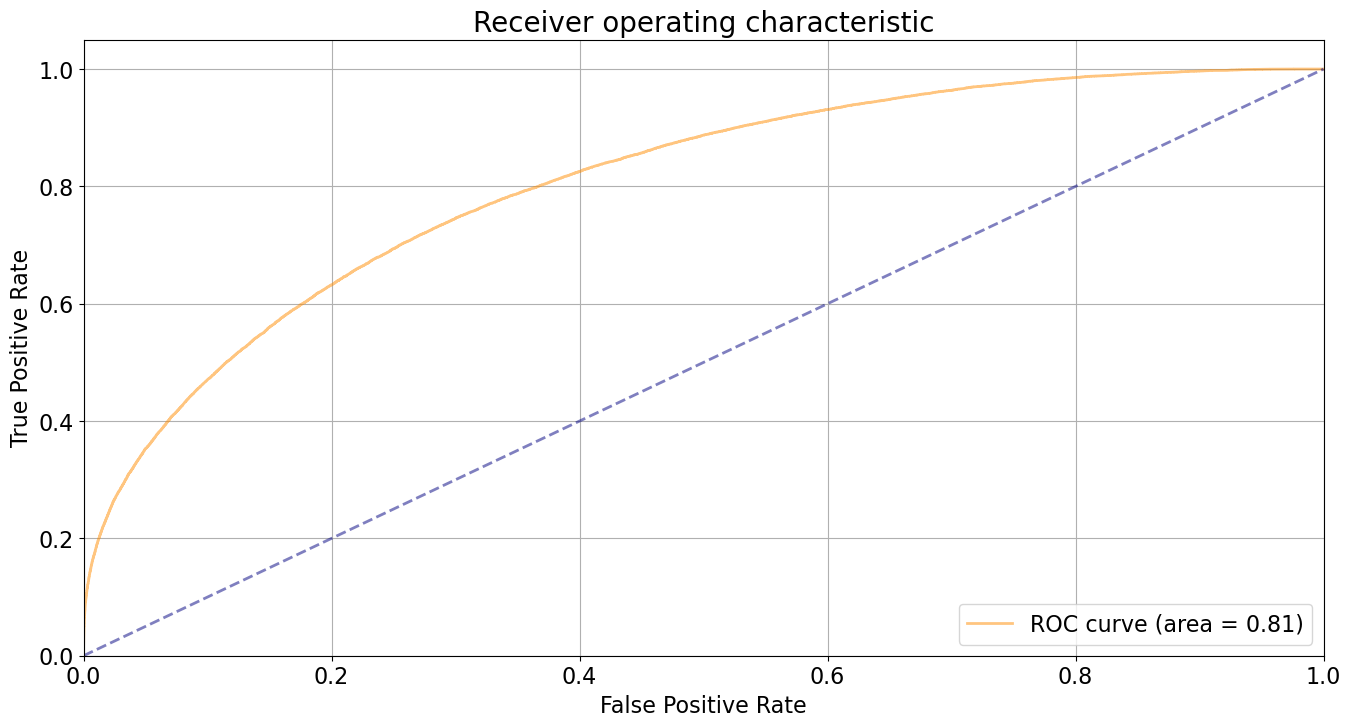

In [16]:
plt.figure(figsize=(16, 8))
lw=2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

### LightGBM

In [33]:
# переведем категориальные фичи в int с помощью  LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in cat_features:
    X[col] = le.fit_transform(X[col])

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,)

In [35]:
from lightgbm import Dataset, LGBMClassifier, train

lgbm = LGBMClassifier(objective='binary',metrics ='auc')

In [37]:
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 69971, number of negative: 1447633
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1748
[LightGBM] [Info] Number of data points in the train set: 1517604, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.046106 -> initscore=-3.029604
[LightGBM] [Info] Start training from score -3.029604


LGBMClassifier(metrics='auc', objective='binary')

In [38]:
lgbm_probs = lgbm.predict_proba(X_test)

In [39]:
# save probabilities only for a positive outcome
lgbm_probs = lgbm_probs[:, 1]

In [47]:
fpr,tpr,_ = roc_curve(y_test, lgbm_probs)
lgbm_auc = auc(fpr, tpr)
print('LightGBM: ROC AUC=%.3f' % (lgbm_auc))

LightGBM: ROC AUC=0.729


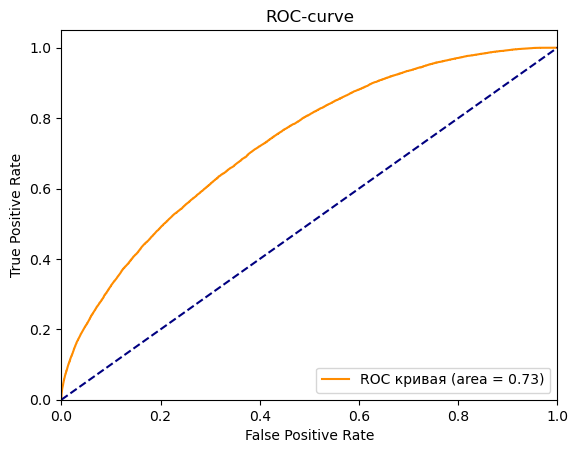

In [46]:
# plotting a graph
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend(loc="lower right")
plt.show()

## XGBoost

In [75]:
import xgboost as xgb
